# Radiology Image Classification

#### Import the required libraries

In [1]:
import numpy as np
import os
import tensorflow as tf
import pandas as pd
import PIL
import matplotlib.pyplot as plt

from tensorflow import keras
from keras import layers, Input, Model
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.losses import SparseCategoricalCrossentropy
from keras.metrics import SparseCategoricalAccuracy
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.optimizers.schedules import ExponentialDecay
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import L2
from sklearn.model_selection import train_test_split

2023-12-24 19:34:40.335945: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-24 19:34:40.355357: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-24 19:34:40.355376: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-24 19:34:40.355847: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-24 19:34:40.359305: I tensorflow/core/platform/cpu_feature_guar

#### Import the datasets

In [2]:
# Import the dataset
training_dir = '/home/mmingo/transfer_files/Chest-Classification'
# Windows PWD: C:/Users/mming/OneDrive/Desktop/Chest-Classification
# OSX PWD: /Users/markmingo/Desktop/MURA-v1.1/train
# Linux PWD: /home/mmingo/transfer_files/Chest-Classification
test_dir = '/home/mmingo/transfer_files/Chest-Classification-Test'
# Windows PWD: C:/Users/mming/OneDrive/Desktop/Chest-Classification-Test
# OSX PWD: 
# Linux PWS: /home/mmingo/transfer_files/Chest-Classification-Test

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)
BATCH_SIZE = 128

VALIDATION_TEST_SPLIT = 690

# Create training set
ds_train = keras.utils.image_dataset_from_directory(
    training_dir,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE),
    seed=123,
    validation_split=0.15,
    subset="training"
)

# Create cross-validation set
ds_validation = keras.utils.image_dataset_from_directory(
    training_dir,
    labels='inferred',
    label_mode='int',
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE),
    seed=123,
    validation_split=0.15,
    subset="validation"
)

# Create test set
ds_test = keras.utils.image_dataset_from_directory(
    test_dir,
    shuffle=False,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE)
)

# Class names
class_names = ds_train.class_names
print(class_names)

Found 6223 files belonging to 3 classes.
Using 5290 files for training.


2023-12-24 19:34:42.007558: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-24 19:34:42.254906: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-24 19:34:42.254943: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-24 19:34:42.258336: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-24 19:34:42.258371: I external/local_xla/xla/stream_executor

Found 6223 files belonging to 3 classes.
Using 933 files for validation.
Found 679 files belonging to 3 classes.
['covid', 'normal', 'pneumonia']


#### Display specific image(s) 

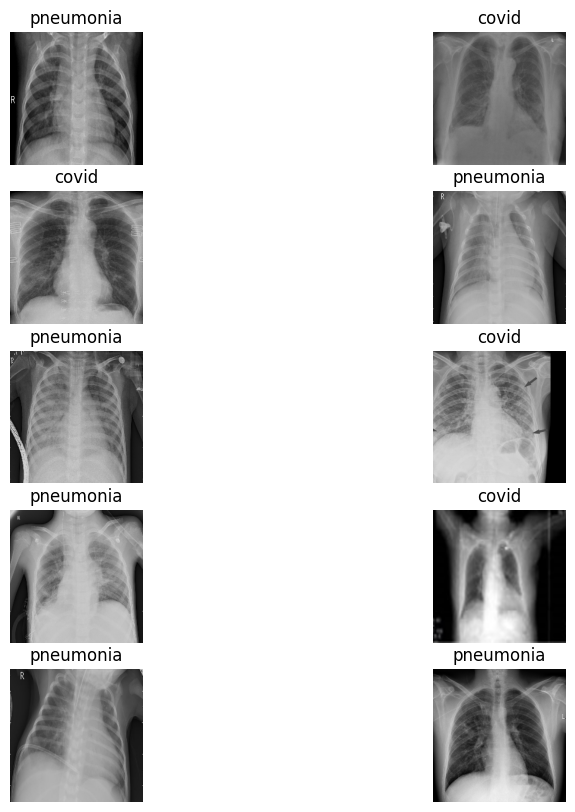

In [3]:
# Visualize the data
plt.figure(figsize=(10, 10))
image, label = next(iter(ds_train))
for images, labels in ds_train.take(1):
    for i in range(10):
        ax = plt.subplot(5, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis('off')

#### Add data augmentation

In [4]:
data_augmentation = Sequential([
    layers.RandomBrightness(0.08),
    layers.RandomContrast(0.2),
    layers.RandomRotation(0.2),
    layers.RandomZoom(-0.1, 0.1),
    layers.GaussianNoise(0.2)
])

#### Configure dataset's for performance

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

ds_train = ds_train.prefetch(buffer_size=AUTOTUNE)
ds_validation = ds_validation.prefetch(buffer_size=AUTOTUNE)

#### Display an image with data augmentation

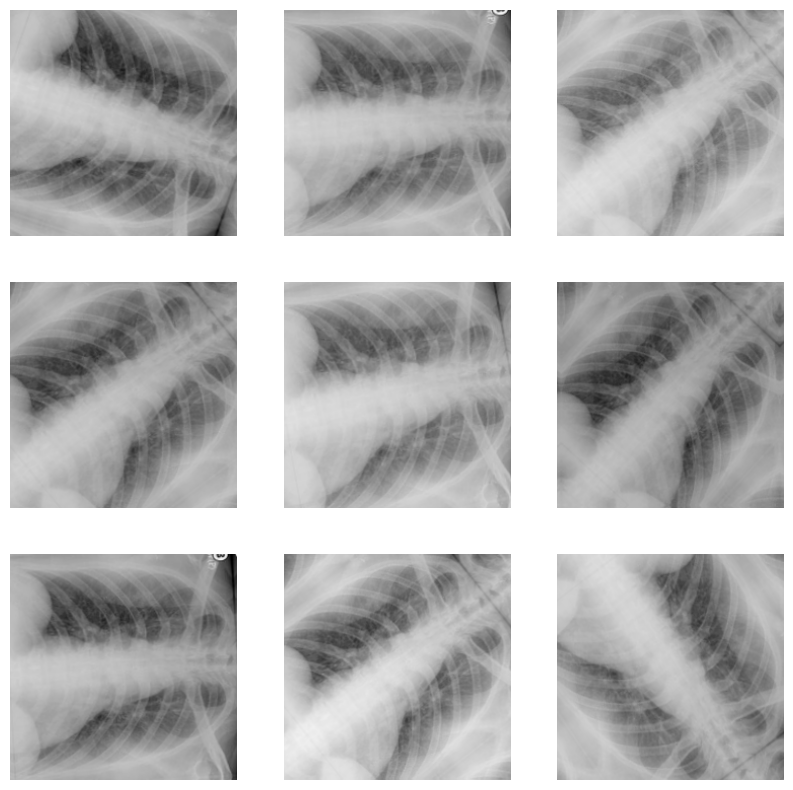

In [6]:
plt.figure(figsize=(10, 10))
for images, _ in ds_train.take(1):
    for i in range(9):
        augmented_image = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image[0].numpy().astype('uint8'))
        plt.axis('off')

### Convert images from RBG to BGR and zero-center each color channel.

###### Reguired for ResNet50 with ImageNet transfer learning.

In [7]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input

#### Create the model

In [8]:
IMG_SHAPE = IMG_SIZE + (3,)

base_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=IMG_SHAPE
)

#### Freeze layers for feature extraction

In [9]:
base_model.trainable = False

#### Model Summary

In [10]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [11]:
image_batch, label_batch = next(iter(ds_train))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2023-12-24 19:34:51.834711: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907


(128, 7, 7, 2048)


#### Add a classification head

In [12]:
global_avg_layer = GlobalAveragePooling2D()
feature_batch_avg = global_avg_layer(feature_batch)
print(feature_batch_avg.shape)

(128, 2048)


#### Add a prediction layer (multi-class classification)

In [13]:
prediction_layer = Dense(len(class_names), activation='softmax', kernel_regularizer=L2(0.01))
prediction_batch = prediction_layer(feature_batch_avg)
print(prediction_batch.shape)

(128, 3)


#### Construct the model

In [14]:
inputs = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_avg_layer(x)
x = Dropout(0.45)(x)
outputs = prediction_layer(x)
model = Model(inputs, outputs)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0     

#### Visual plot of the model

In [15]:
tf.keras.utils.plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


#### Compile the model

In [16]:
alpha = 1e-4

pre_lr_schedule = ExponentialDecay(
    alpha,
    decay_steps= 10000,
    decay_rate=0.5,
    staircase=False
)

model.compile(
    optimizer=Adam(learning_rate=pre_lr_schedule),
    loss=SparseCategoricalCrossentropy(from_logits=False),
    metrics=[SparseCategoricalAccuracy(name='accuracy')]
)


#### Train the model

In [17]:
history = model.fit(
    ds_train,
    epochs=10,
    validation_data=ds_validation
)

Epoch 1/10


2023-12-24 19:34:57.771584: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid values


 1/42 [..............................] - ETA: 2:09 - loss: 1.7407 - accuracy: 0.3203

2023-12-24 19:34:58.143849: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f3d9d4e57d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-24 19:34:58.143871: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090 Ti, Compute Capability 8.6
2023-12-24 19:34:58.158030: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1703464498.220445    6513 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


42/42 [==============================] - 14s 256ms/step - loss: 1.4971 - accuracy: 0.4115 - val_loss: 1.0590 - val_accuracy: 0.5627
Epoch 2/10
 2/42 [>.............................] - ETA: 6s - loss: 1.1944 - accuracy: 0.4961 

2023-12-24 19:35:10.025634: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid values


42/42 [==============================] - 9s 198ms/step - loss: 1.1349 - accuracy: 0.5497 - val_loss: 0.8867 - val_accuracy: 0.6592
Epoch 3/10
 2/42 [>.............................] - ETA: 6s - loss: 1.1505 - accuracy: 0.5391 

2023-12-24 19:35:19.410481: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid values


42/42 [==============================] - 9s 198ms/step - loss: 0.9470 - accuracy: 0.6221 - val_loss: 0.7964 - val_accuracy: 0.7074
Epoch 4/10
 2/42 [>.............................] - ETA: 6s - loss: 0.7104 - accuracy: 0.7305 

2023-12-24 19:35:28.799573: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid values


42/42 [==============================] - 9s 198ms/step - loss: 0.8471 - accuracy: 0.6820 - val_loss: 0.7054 - val_accuracy: 0.7588
Epoch 5/10
 2/42 [>.............................] - ETA: 6s - loss: 0.7322 - accuracy: 0.7344 

2023-12-24 19:35:38.180429: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid values


42/42 [==============================] - 9s 196ms/step - loss: 0.7689 - accuracy: 0.7204 - val_loss: 0.6572 - val_accuracy: 0.7835
Epoch 6/10
 2/42 [>.............................] - ETA: 5s - loss: 0.7772 - accuracy: 0.7148 

2023-12-24 19:35:47.497116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid values


42/42 [==============================] - 9s 192ms/step - loss: 0.7191 - accuracy: 0.7425 - val_loss: 0.6260 - val_accuracy: 0.8006
Epoch 7/10
 2/42 [>.............................] - ETA: 5s - loss: 0.7302 - accuracy: 0.7383 

2023-12-24 19:35:56.616415: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid values


42/42 [==============================] - 9s 192ms/step - loss: 0.6697 - accuracy: 0.7561 - val_loss: 0.6153 - val_accuracy: 0.8028
Epoch 8/10
 2/42 [>.............................] - ETA: 5s - loss: 0.5238 - accuracy: 0.7930 

2023-12-24 19:36:05.723875: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid values


42/42 [==============================] - 9s 191ms/step - loss: 0.6427 - accuracy: 0.7743 - val_loss: 0.5920 - val_accuracy: 0.8081
Epoch 9/10
 2/42 [>.............................] - ETA: 5s - loss: 0.6721 - accuracy: 0.7852 

2023-12-24 19:36:14.799797: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid values


42/42 [==============================] - 9s 192ms/step - loss: 0.6294 - accuracy: 0.7881 - val_loss: 0.5663 - val_accuracy: 0.8189
Epoch 10/10
 2/42 [>.............................] - ETA: 6s - loss: 0.6410 - accuracy: 0.7930 

2023-12-24 19:36:23.946210: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid values


42/42 [==============================] - 9s 192ms/step - loss: 0.6119 - accuracy: 0.7807 - val_loss: 0.5388 - val_accuracy: 0.8253


#### Accuracy: Training & validation

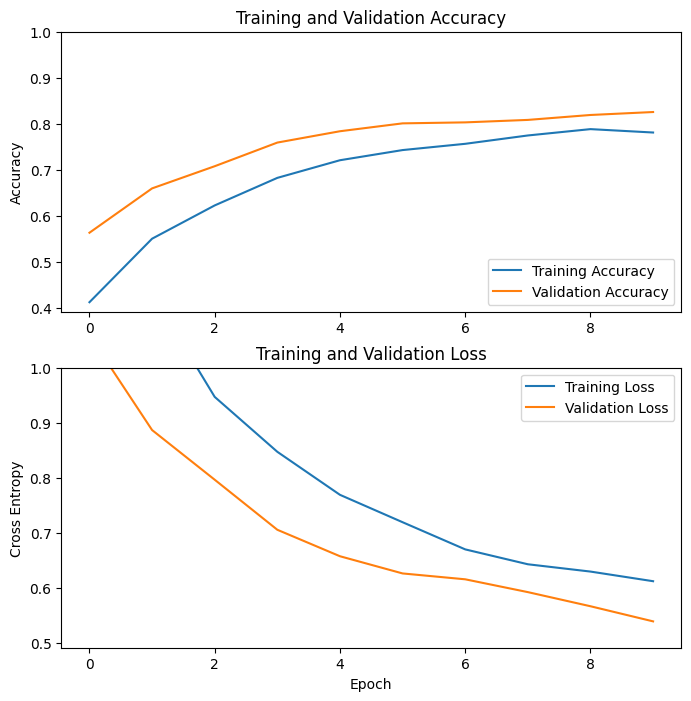

In [18]:
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Loss')
plt.show()

In [19]:
print("GPU's: ", len(tf.config.list_physical_devices('GPU')))

GPU's:  1


#### Unfreeze the last layer of ResNet50 & Recompile

In [20]:
base_model.trainable = True
set_trainable = False
for layer in base_model.layers:
    if layer.name == 'conv5_block3_3_conv' or layer.name == 'conv5_block3_2_conv': #or layer.name == 'conv5_block3_1_conv'
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [21]:
epochs = 30
batch_size = 256

initial_learning_rate = alpha
learning_rate_decay_factor = 0.93
steps_per_epoch = 1000

lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps= steps_per_epoch,
    decay_rate=learning_rate_decay_factor,
    staircase=False
)

model.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss=SparseCategoricalCrossentropy(from_logits=False),
    metrics=[SparseCategoricalAccuracy(name='accuracy')])

In [22]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

#### Train the model after hyperparameter tuning

In [23]:
history_fine = model.fit(ds_train,
                         epochs=epochs,
                         batch_size=batch_size,
                         initial_epoch=history.epoch[-1],
                         validation_data=ds_validation,
                         validation_freq=1)

Epoch 10/30


2023-12-24 19:36:34.932423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid values


42/42 [==============================] - 17s 243ms/step - loss: 0.5112 - accuracy: 0.8325 - val_loss: 0.3888 - val_accuracy: 0.8864
Epoch 11/30
 2/42 [>.............................] - ETA: 6s - loss: 0.4872 - accuracy: 0.8477 

2023-12-24 19:36:49.974821: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid values


42/42 [==============================] - 9s 193ms/step - loss: 0.3914 - accuracy: 0.8854 - val_loss: 0.3787 - val_accuracy: 0.8960
Epoch 12/30
 2/42 [>.............................] - ETA: 6s - loss: 0.3453 - accuracy: 0.8984 

2023-12-24 19:36:59.164630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid values


42/42 [==============================] - 9s 195ms/step - loss: 0.3484 - accuracy: 0.8947 - val_loss: 0.3617 - val_accuracy: 0.8960
Epoch 13/30
 2/42 [>.............................] - ETA: 6s - loss: 0.3379 - accuracy: 0.8828 

2023-12-24 19:37:08.390585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid values


42/42 [==============================] - 9s 195ms/step - loss: 0.3252 - accuracy: 0.9068 - val_loss: 0.4010 - val_accuracy: 0.8789
Epoch 14/30
 2/42 [>.............................] - ETA: 6s - loss: 0.2879 - accuracy: 0.9102 

2023-12-24 19:37:17.652259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid values


42/42 [==============================] - 9s 196ms/step - loss: 0.3030 - accuracy: 0.9117 - val_loss: 0.3309 - val_accuracy: 0.9035
Epoch 15/30
 2/42 [>.............................] - ETA: 6s - loss: 0.2808 - accuracy: 0.9219 

2023-12-24 19:37:26.955576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid values


42/42 [==============================] - 9s 193ms/step - loss: 0.2979 - accuracy: 0.9153 - val_loss: 0.3020 - val_accuracy: 0.9143
Epoch 16/30
 2/42 [>.............................] - ETA: 6s - loss: 0.2599 - accuracy: 0.9414 

2023-12-24 19:37:36.133175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid values


42/42 [==============================] - 9s 191ms/step - loss: 0.2710 - accuracy: 0.9280 - val_loss: 0.3244 - val_accuracy: 0.9132
Epoch 17/30
 2/42 [>.............................] - ETA: 6s - loss: 0.2473 - accuracy: 0.9492 

2023-12-24 19:37:45.216427: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid values


42/42 [==============================] - 9s 192ms/step - loss: 0.2731 - accuracy: 0.9219 - val_loss: 0.2755 - val_accuracy: 0.9271
Epoch 18/30
 2/42 [>.............................] - ETA: 6s - loss: 0.2011 - accuracy: 0.9414 

2023-12-24 19:37:54.382791: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid values


42/42 [==============================] - 9s 194ms/step - loss: 0.2468 - accuracy: 0.9333 - val_loss: 0.2746 - val_accuracy: 0.9314
Epoch 19/30
 2/42 [>.............................] - ETA: 6s - loss: 0.1780 - accuracy: 0.9648 

2023-12-24 19:38:03.537764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid values


42/42 [==============================] - 9s 195ms/step - loss: 0.2395 - accuracy: 0.9340 - val_loss: 0.2610 - val_accuracy: 0.9335
Epoch 20/30
 2/42 [>.............................] - ETA: 6s - loss: 0.1735 - accuracy: 0.9648 

2023-12-24 19:38:12.764232: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid values


42/42 [==============================] - 9s 195ms/step - loss: 0.2413 - accuracy: 0.9359 - val_loss: 0.2535 - val_accuracy: 0.9314
Epoch 21/30
 2/42 [>.............................] - ETA: 5s - loss: 0.2603 - accuracy: 0.9180 

2023-12-24 19:38:22.046984: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid values


42/42 [==============================] - 9s 193ms/step - loss: 0.2309 - accuracy: 0.9393 - val_loss: 0.2571 - val_accuracy: 0.9314
Epoch 22/30
 2/42 [>.............................] - ETA: 6s - loss: 0.2345 - accuracy: 0.9336 

2023-12-24 19:38:31.159518: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid values


42/42 [==============================] - 9s 195ms/step - loss: 0.2286 - accuracy: 0.9380 - val_loss: 0.2772 - val_accuracy: 0.9185
Epoch 23/30
 2/42 [>.............................] - ETA: 5s - loss: 0.1975 - accuracy: 0.9492 

2023-12-24 19:38:40.413849: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid values


42/42 [==============================] - 9s 195ms/step - loss: 0.2129 - accuracy: 0.9431 - val_loss: 0.2650 - val_accuracy: 0.9303
Epoch 24/30
 2/42 [>.............................] - ETA: 5s - loss: 0.2631 - accuracy: 0.9414 

2023-12-24 19:38:49.638553: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid values


42/42 [==============================] - 9s 194ms/step - loss: 0.2096 - accuracy: 0.9437 - val_loss: 0.2647 - val_accuracy: 0.9303
Epoch 25/30
 2/42 [>.............................] - ETA: 6s - loss: 0.1870 - accuracy: 0.9414 

2023-12-24 19:38:58.866505: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid values


42/42 [==============================] - 9s 194ms/step - loss: 0.2060 - accuracy: 0.9442 - val_loss: 0.2544 - val_accuracy: 0.9314
Epoch 26/30
 2/42 [>.............................] - ETA: 6s - loss: 0.2255 - accuracy: 0.9375 

2023-12-24 19:39:08.038473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid values


42/42 [==============================] - 9s 195ms/step - loss: 0.2143 - accuracy: 0.9403 - val_loss: 0.2531 - val_accuracy: 0.9335
Epoch 27/30
 2/42 [>.............................] - ETA: 6s - loss: 0.1743 - accuracy: 0.9492 

2023-12-24 19:39:17.288123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid values


42/42 [==============================] - 9s 192ms/step - loss: 0.2044 - accuracy: 0.9442 - val_loss: 0.2305 - val_accuracy: 0.9389
Epoch 28/30
 2/42 [>.............................] - ETA: 6s - loss: 0.1764 - accuracy: 0.9609 

2023-12-24 19:39:26.387346: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid values


42/42 [==============================] - 9s 195ms/step - loss: 0.1921 - accuracy: 0.9501 - val_loss: 0.2501 - val_accuracy: 0.9346
Epoch 29/30
 2/42 [>.............................] - ETA: 6s - loss: 0.1659 - accuracy: 0.9609 

2023-12-24 19:39:35.669568: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid values


42/42 [==============================] - 9s 193ms/step - loss: 0.1873 - accuracy: 0.9507 - val_loss: 0.2869 - val_accuracy: 0.9196
Epoch 30/30
 2/42 [>.............................] - ETA: 6s - loss: 0.1593 - accuracy: 0.9609 

2023-12-24 19:39:44.833559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: invalid values


42/42 [==============================] - 9s 194ms/step - loss: 0.1773 - accuracy: 0.9520 - val_loss: 0.2421 - val_accuracy: 0.9346


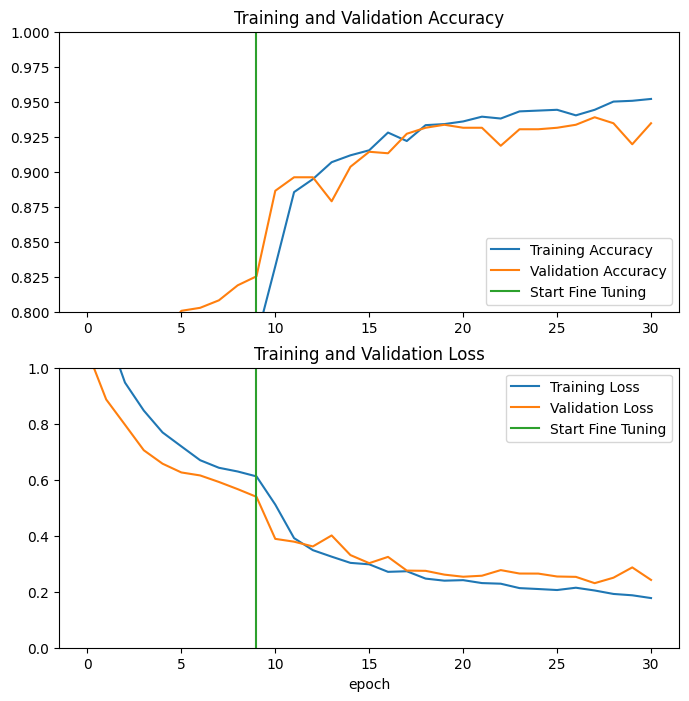

In [24]:
accuracy += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([9,9],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([9,9],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

#### Evaluate on unseen data (test set)

In [26]:
model.evaluate(ds_test)

6/6 [==============================] - 2s 387ms/step - loss: 0.2217 - accuracy: 0.9470


[0.22172613441944122, 0.9469808340072632]

In [25]:
keras.backend.clear_session()